In [16]:
import sys
sys.version

'3.10.9 (main, Dec 15 2022, 10:44:50) [Clang 14.0.0 (clang-1400.0.29.202)]'

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from typing import List

%matplotlib inline

In [18]:
# ****CONSTANTS****
T = 298 #(*Cell temp. in Kelvin*)
R = 0.0083 #(*kJ/M/K*)
F = 0.0965 #(*kJ/M/mV*)
S = 2.303*R*T
Z = 2.303*R*T/F
u = 0.861 #(* u=\[CapitalDelta]\[Psi]/\[CapitalDelta]p *)

In [90]:
# (****PARAMETERS****)
r_cm = 3.35 # (*cell volume / mt volume ratio*)
b_N = 5 # (*buffering capacity coefficient for NAD*)
c_t = 270 # (*total concentration of cytochrome c in uM*)
ubq_t = 1350 # (*total concentration of ubiquinone in uM*)
n_t = 2970 # (*total concentration of NAD in uM*)

p_D = 0.8 # (*Dehydrogenation sensitivity to NAD ratio*)

k_DH = 96293 # (*Substrate dehydrogenation parameters in uM/min*)
k_mN = 100
k_C1 = 819.61 # (*in uM/mV/min*)
k_C3 = 467.90 # (*in uM/mV/min*)
k_C4 = 12.348 # (*in uM/min*)
k_mO = 120 # (*uM_apparent k_mO]=0.8 uM*)
k_SN = 117706 # (*in uM/min*)
k_EX = 187185 # (*in uM/min*)
k_mADP = 3.5 # (*uM*)
k_PI = 238.11 # (*in /uM/min*)
k_UT = 12244 # (*ATP usage rate in uM/min# 12244(low work)-61220(high work)*)
k_mA = 150 # (*uM*)
k_LK1 = 8.5758 # (*normally 8.5758 in uM/min*)
k_LK2 = 0.038
k_fAK = 862.10 # (*adenylate kinase forward rate constant in uM/min*)
k_bAK = 22.747 # (*adenylate kinase reverse rate constant in uM/min*)
k_fCK = 1.9258 # (*creatine kinase forward rate constant in uM/min# times \ 0.656 for CHF (Weiss et al. (2005)*)
k_bCK = 0.00087538 # (*creatine kinase reverse rate constant in uM/min*)

a_eSUM = 6700.2 # (*uM_total cytosolic adenine nucleotide conc.*)
a_iSUM = 16260 # (*uM_total mitochondrial adenine nucleotide conc.*)
c_SUM = 25000 # (*total creatine concentration_Normal: 25000 (orig. model)_\ CHF: 16100 (Weiss et al. (2005)*)
p_SUM = 45582#(*total phosphate pool_not actually used!!*)
mg_fe = 4000 # (*uM_free cytosolic magnesium conc.*)
mg_fi = 380 # (*uM_free mt. magnesium conc.*)
k_DTe = 24 # (*uM_Mg diss. const. for cyt. ATP*)
k_DDe = 347 # (*uM_Mg diss. const. for cyt. ADP*)
k_DTi = 17 # (*uM_Mg diss. const. for mt. ATP*)
k_DDi = 282 # (*uM_Mg diss. const. for mt. ADP*)
pH_e = 7.0
h_e = 1000000 * 10**(-pH_e)
dpH = 0.001
c_buffi = 0.022 # (* moles of protons/pH unit_buffer capacity of matrix*)
pK_a = 6.8 # (*phosphate proton-buffering midpoint*)
n_A = 2.5 # (*H+/ATP stoichiometry of the synthase*)
deltaG_P0 = 31.9 # (*kJ/mol*)
e_mN0 = -320 # (*standard redox potential of NAD couple_in mV*)
e_mU0 = 85 # (*standard redox potential of UQ couple_in mV*)
e_mc0 = 250 # (*standard redox potential of cyt. c couple_in mV*)
a_t = 135 # (*total conc. of cyt. a_in uM*)
e_ma0 = 540 # (*standard redox potential of cyt. a couple_in mV*)

In [111]:
def mitochondrial_simulator(t, Y):
    
    """
    A simulator of mitochondrial energetics
    Returns a list of vectors, each containing the estimated values for each function with the range of t
    Parameters
    ----------
    Y : list(float)
    A vector of initial values
    t : list(float)
    A range of times
    """
    
   # initial values
    nadh_0 = Y[0]
    uqh_0 = Y[1]
    c2plus_0 = Y[2]
    o2_0 = Y[3]
    h_i_0 = Y[4]
    atp_ti_0 = Y[5]
    pi_ti_0 = Y[6]
    atp_te_0 = Y[7]
    adp_te_0 = Y[8]
    pi_te_0 = Y[9]
    pcr_0 = Y[10]
    
    # additional kinetic equations & calculations
    adp_ti = a_iSUM - atp_ti_0
    atp_fe = atp_te_0 / (1 + mg_fe / k_DTe)
    nad = n_t - nadh_0
    v_DH = k_DH * ( 1/(1 + k_mN) / ((nad/nadh_0)**p_D) ) # (*Substrate dehydrogenation*)
    uq = ubq_t - uqh_0
    c3plus = c_t - c2plus_0
    e_mN = e_mN0 + ((Z/2) * np.log10(nad / nadh_0))
    e_mU = e_mU0 + ((Z/2) * np.log10(uq / uqh_0))
    e_mc = e_mc0 + Z * np.log10(c3plus / c2plus_0)
    pH_i = -np.log10(h_i_0 / 1000000)
    deltapH = Z*(pH_i - pH_e)
    deltap = (1 / (1 - u)) * deltapH
    e_ma = e_mc + deltap*(2 + (2 * u)) / 2
    a_3over2 = 10**((e_ma - e_ma0) / Z) # (*a3plus/a2plus ratio*)
    a2plus = a_t / (1 + a_3over2)
    a3plus = a_t - a2plus
    delta_psi = -(deltap - deltapH)
    deltaG_C1 = e_mU - e_mN - deltap * 4/2
    deltaG_C3 = e_mc - e_mU - deltap * (4 - 2*u) / 2
    deltaG_P = deltaG_P0 / F + Z * np.log10(1000000*atp_ti_0 / (adp_ti * pi_ti_0));
    deltaG_SN = n_A * deltap - deltaG_P
    v_C1 = k_C1 * deltaG_C1 # (*Complex I*)
    v_C3 = k_C3 * deltaG_C3 #
    v_C4 = k_C4 * a2plus * c2plus_0 * 1/(1 + k_mO/o2_0)
    gamma = 10**(deltaG_SN/Z)
    v_SN = k_SN * (gamma - 1)/(gamma + 1) # (*ATP Synthase*)
    v_LK = k_LK1 * (np.exp(k_LK2 * deltap) - 1) # (*Proton leak*)
    atp_me = atp_te_0 - atp_fe
    adp_fe = adp_te_0 /(1 + mg_fe / k_DDe)
    adp_me = adp_te_0 - adp_fe
    atp_fi = atp_ti_0 / (1 + mg_fi / k_DTi)
    atp_mi = atp_ti_0 - atp_fi
    amp_e = a_eSUM - atp_te_0 - adp_te_0
    cr = c_SUM - pcr_0
    psi_i = 0.65 * delta_psi
    psi_e = -0.35 * delta_psi
    pi_je = pi_te_0 / (1 + 10**(pH_e - pK_a))
    pi_ji = pi_ti_0/(1 + 10**(pH_i - pK_a))
    adp_fi = adp_ti / (1 + mg_fi / k_DDi)
    adp_mi = adp_ti - adp_fi
    v_AK = (k_fAK * adp_fe * adp_me) - (k_bAK * atp_me * amp_e) # (*adenylate kinase*)
    v_CK = (k_fCK * adp_te_0 * pcr_0 * h_e) - (k_bCK * atp_te_0 * cr) # (*creatine kinase*)
    v_EX = k_EX * (adp_fe / (adp_fe + atp_fe * 10**(-psi_e / Z)) - adp_fi / (adp_fi + atp_fi * 10**(-psi_i / Z))) * (1/(1 + k_mADP/adp_fe)) # (*ANT*)
    v_PI = k_PI * (pi_je * h_e - pi_ji * h_i_0) # (*phosphate transporter*)
    v_UT = k_UT * 1/(1 + k_mA / atp_te_0) # (*ATP usage*)
    atp_tot = (atp_ti_0 / r_cm) + atp_te_0 # (*calculates total cell [ATP]*)
    pi_tot = (pi_ti_0 / r_cm) + pi_te_0 # (*calculates total cell [Pi]*)
    adp_tot = (adp_ti / r_cm) + adp_te_0 # (*calculates total cell [ADP]*)
    c_0i = (10**(-pH_i) - 10**((-pH_i) - dpH)) / dpH # (*natural buffer capacity in matrix*)
    c_0e = (10**(-pH_e) - 10**((-pH_e) - dpH)) / dpH # (*natural buffer capacity in cytosol*)
    r_buffi = c_buffi / c_0i # (*buffering capacity coefficient for matrix*)
    
    # differential equations
    f0 = (v_DH - v_C1) * r_cm / b_N # nadh_of_t
    f1 = (v_C1 - v_C3) * r_cm # uqh_of_t
    f2 = (v_C3 - 2 * v_C4) * 2 * r_cm # c2plus_of_t
    f3 = 0 # # (*or o2'[t]\[Equal]-v_C4]*) # o2_of_t
    f4 = -((2 * (2 + 2 * u) * v_C4) + ((4 - 2*u)*v_C3) + (4 * v_C1) - (n_A * v_SN) - (u * v_EX) - ((1 - u) * v_PI) - (v_LK)) * r_cm / r_buffi # h_i_of_t 
    f5 = (v_SN - v_EX) * r_cm # atp_ti_of_t
    f6 = (v_PI - v_SN) * r_cm # pi_ti_of_t
    f7 = (v_EX - v_UT + v_AK + v_CK) # atp_te_of_t
    f8 = (v_UT - v_EX - (2 * v_AK) - v_CK) # adp_te_of_t
    f9 = (v_UT - v_PI) # pi_te_of_t
    f10 = -v_CK # pcr_of_t
    
    return [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]

In [105]:
# initial values (*from BK*)
nadh_0 = 822
uqh_0 = 1143
c2plus_0 = 60.89
o2_0 = 240 # (*from BK (1991)*)
h_i_0 = 0.037
atp_ti_0 = 6987
pi_ti_0 = 7020
atp_te_0 = 6668
adp_te_0 = 31.7
pi_te_0 = 2599
pcr_0 = 12219

Y_0 = [nadh_0, uqh_0, c2plus_0, o2_0, h_i_0, atp_ti_0, pi_ti_0, atp_te_0, adp_te_0, pi_te_0, pcr_0]
Y_0
# t  = np.linspace(0, .05, 10)

[822, 1143, 60.89, 240, 0.037, 6987, 7020, 6668, 31.7, 2599, 12219]

In [113]:
soln = solve_ivp(mitochondrial_simulator, [0, 0.01], Y_0)

/var/folders/46/s5qdz_9d0_bbf06ytkft8v040000gp/T/ipykernel_10656/3340611816.py:36: RuntimeWarning: invalid value encountered in log10
  e_mc = e_mc0 + Z * np.log10(c3plus / c2plus_0)
/var/folders/46/s5qdz_9d0_bbf06ytkft8v040000gp/T/ipykernel_10656/3340611816.py:47: RuntimeWarning: invalid value encountered in log10
  deltaG_P = deltaG_P0 / F + Z * np.log10(1000000*atp_ti_0 / (adp_ti * pi_ti_0));


In [115]:
soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.713e-05 ...  9.991e-03  1.000e-02]
        y: [[ 8.220e+02  8.220e+02 ...  7.920e+02  7.920e+02]
            [ 1.143e+03  1.143e+03 ...  1.134e+03  1.134e+03]
            ...
            [ 2.599e+03  2.599e+03 ...  2.597e+03  2.597e+03]
            [ 1.222e+04  1.222e+04 ...  1.222e+04  1.222e+04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3404
     njev: 0
      nlu: 0

In [118]:
Y, t = soln['y'], soln['t']

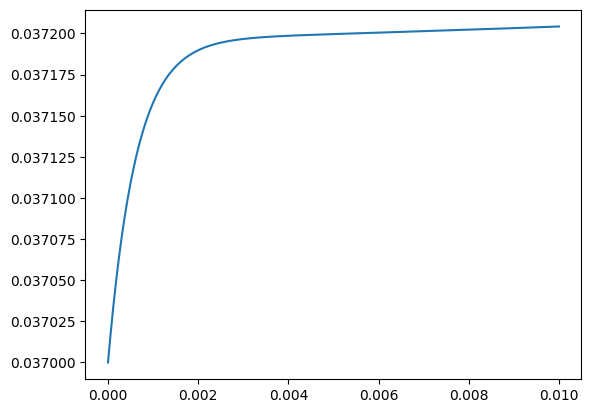

In [122]:
plt.plot(t, Y[4])